In [4]:
!cd

In [5]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
import scanpy as sc
import sklearn
from scipy.sparse import csr_matrix
from sklearn.metrics.cluster import adjusted_rand_score
import copy


In [6]:
# os.chdir('/Users/evanli/Documents/Research_datasets/PBMC_Hao')
# adata_raw = sc.read_h5ad(r"C:\Users\evanlee\Documents\Research_datasets\GSE164378\Hao_PBMC_GSE164378.h5ad")
adata_raw = sc.read_h5ad('/home/jovyan/work/Research_datasets/GSE164378/Hao_PBMC_GSE164378.h5ad')
print(adata_raw.shape)  # row is cells, column is gene
# (161764, 20568)
# (161764, 33538)

(161764, 33538)


In [7]:
# CPM
# Total-count normalize the data matrix X to 10,000 reads per cell
# sc.pp.normalize_total(adata_raw, target_sum=1e6)

# Log
sc.pp.log1p(adata_raw)

In [8]:
# view adata.X
rows, cols = adata_raw.X[:5,:].nonzero()
i = 0
for row, col in zip(rows, cols):
    if i == 20: break
    print(f'Row {row}, Column {col}, Value {adata_raw.X[row, col]}')
    i += 1


Row 0, Column 12, Value 0.6931471824645996
Row 0, Column 43, Value 1.0986123085021973
Row 0, Column 48, Value 1.0986123085021973
Row 0, Column 53, Value 1.0986123085021973
Row 0, Column 55, Value 1.7917594909667969
Row 0, Column 66, Value 0.6931471824645996
Row 0, Column 77, Value 1.0986123085021973
Row 0, Column 78, Value 1.7917594909667969
Row 0, Column 89, Value 1.0986123085021973
Row 0, Column 93, Value 1.3862943649291992
Row 0, Column 102, Value 1.0986123085021973
Row 0, Column 154, Value 2.890371799468994
Row 0, Column 178, Value 1.0986123085021973
Row 0, Column 185, Value 0.6931471824645996
Row 0, Column 190, Value 0.6931471824645996
Row 0, Column 201, Value 2.1972246170043945
Row 0, Column 224, Value 1.0986123085021973
Row 0, Column 240, Value 0.6931471824645996
Row 0, Column 259, Value 0.6931471824645996
Row 0, Column 261, Value 1.9459102153778076


In [9]:
# assuming data.X is your sparse CSR matrix
num_nonzero = adata_raw.X.getnnz(axis=1)  # number of nonzeros for each row
num_nonzero[:10]

array([2915, 1617, 1381, 1890, 1621, 1633, 2672, 1122, 1375, 1200])

In [10]:
# All level 1 celltypes
types = np.unique(adata_raw.obs['celltype.l1']).tolist()
print(types)
# cell count in each celltype
adata_raw.obs['celltype.l1'].value_counts()

['B', 'CD4 T', 'CD8 T', 'DC', 'Mono', 'NK', 'other', 'other T']


celltype.l1
Mono       49010
CD4 T      41001
CD8 T      25469
NK         18664
B          13800
other T     6789
DC          3589
other       3442
Name: count, dtype: int64

## UMAP

In [11]:
# Delete the 'neighbors' key from adata.uns
# if 'neighbors' already exists in adata.uns, error would occurs at sc.pp.neighbors
if 'neighbors' in adata_raw.uns:
    del adata_raw.uns['neighbors']

In [12]:
# PCA
sc.tl.pca(adata_raw, svd_solver='arpack')

# Neighborhood graph
sc.pp.neighbors(adata_raw, n_neighbors=15, n_pcs=40)

2023-11-28 13:50:04.588195: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-28 13:50:04.944546: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-28 13:50:05.786661: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-11-28 13:50:05.786784: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [13]:
# create color palette for cell types
import seaborn as sns

palette = sns.color_palette('tab10', n_colors=len(types)+1)
del palette[7]
palette

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333)]

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


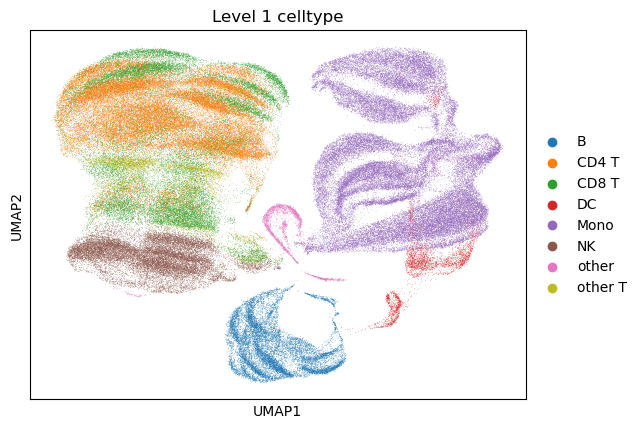

In [14]:
# UMAP

sc.tl.umap(adata_raw)
# sc.pl.umap(adata)
sc.pl.umap(adata_raw, color='celltype.l1', title='Level 1 celltype', palette=palette)

In [15]:
# Leiden clustering
sc.tl.leiden(adata_raw)

IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


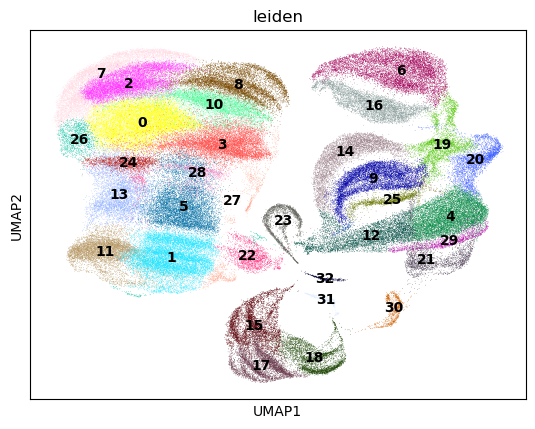

In [16]:
# Plot Leiden
sc.pl.umap(adata_raw, color='leiden', legend_loc="on data")

## Representative cells
Select top 20% clustering coefficient cells in each cell type

In [17]:
umap_adja_matrix = adata_raw.obsp['connectivities']
umap_adja_matrix

<161764x161764 sparse matrix of type '<class 'numpy.float32'>'
	with 3423644 stored elements in Compressed Sparse Row format>

In [18]:
# Clustering coefficient
import networkx as nx

G = nx.from_scipy_sparse_array(umap_adja_matrix)
print(G)

clustering_coeff = nx.clustering(G)
print(len(clustering_coeff))

Graph with 161764 nodes and 1711822 edges
161764


In [19]:
adata_raw.obs.columns

Index(['celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'Batch', 'donor',
       'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'leiden'],
      dtype='object')

In [20]:
# Select top 20% clustering coefficient cells in each cell type
alltype_selected = dict()

for celltype in types:
    # select cells from one celltype
    celltype_idx = np.where(adata_raw.obs['celltype.l1'] == celltype)[0]
    celltype_coeff = {node_idx: clustering_coeff[node_idx] for node_idx in celltype_idx}
    
    top20_count = int(len(celltype_coeff) * 0.2)
    top20_indices = sorted(celltype_coeff, key=celltype_coeff.get, reverse=True)[:top20_count]
    celltype_selected = {node_idx: celltype_coeff[node_idx] for node_idx in top20_indices}
    alltype_selected.update(celltype_selected)
    print(celltype, len(celltype_selected))

B 2760
CD4 T 8200
CD8 T 5093
DC 717
Mono 9802
NK 3732
other 688
other T 1357


In [21]:
len(alltype_selected)

32349

In [22]:
# add column to adata.obs
is_representative = ['Yes' if cell in alltype_selected.keys() else 'No' for cell in clustering_coeff.keys()]
is_representative = np.array(is_representative)

# Add is_representative (Yes or No) to data.obs
adata_raw.obs['is_representative'] = is_representative
# adata_raw.obs.head()

In [23]:
sum(adata_raw.obs['is_representative'] == 'Yes')

32349

In [24]:
# Add a column: Cluster_representative
# 在 representative cell 中，加上 cluster
clus_rep = []
for i in range(adata_raw.shape[0]):
    if adata_raw.obs['is_representative'][i] == 'Yes':
        # Yes_cluster_name
        clus_rep.append(adata_raw.obs['is_representative'][i] + '_' + adata_raw.obs['celltype.l1'][i])
    else:
        # No
        clus_rep.append(adata_raw.obs['is_representative'][i])

adata_raw.obs['cluster_representative'] = clus_rep

In [25]:
adata_raw.obs.head()

,celltype.l1,celltype.l2,celltype.l3,Phase,Batch,donor,nCount_ADT,nFeature_ADT,nCount_RNA,nFeature_RNA,leiden,is_representative,cluster_representative
L1_AAACCCAAGAAACTCA,Mono,CD14 Mono,CD14 Mono,G1,Batch1,P2,7535,217,10823,2915,4,No,No
L1_AAACCCAAGACATACA,CD4 T,CD4 TCM,CD4 TCM_1,G1,Batch1,P1,6013,209,5864,1617,0,No,No
L1_AAACCCACAACTGGTT,CD8 T,CD8 Naive,CD8 Naive,S,Batch1,P4,6620,213,5067,1381,2,No,No
L1_AAACCCACACGTACTA,NK,NK,NK_2,G1,Batch1,P3,3567,202,4786,1890,11,No,No
L1_AAACCCACAGCATACT,CD8 T,CD8 Naive,CD8 Naive,G1,Batch1,P4,6402,215,6505,1621,2,No,No


## Plot representative cell UMAP

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


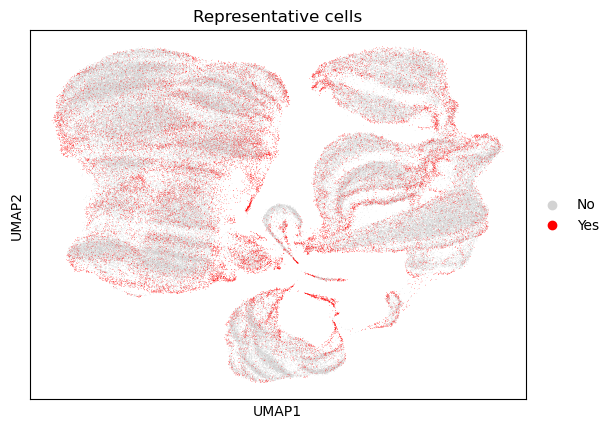

In [26]:
# Plot Yes/No representative cells
sc.pl.umap(adata_raw, color='is_representative', title='Representative cells', palette=['#D3D3D3', 'red'])

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


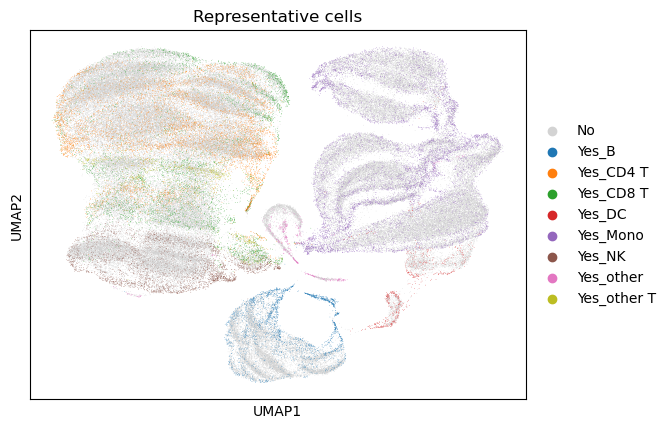

In [27]:
# Also differentiating representative cells from different cell types
sc.pl.umap(adata_raw, color='cluster_representative', title='Representative cells', palette=['#D3D3D3']+palette)  #, palette= ['#D3D3D3'] + palette

## Export representative cells adata

In [28]:
# view adata.X
rows, cols = adata_raw.X[:5,:].nonzero()
i = 0
for row, col in zip(rows, cols):
    if i == 20: break
    print(f'Row {row}, Column {col}, Value {adata_raw.X[row, col]}')
    i += 1


Row 0, Column 12, Value 0.6931471824645996
Row 0, Column 43, Value 1.0986123085021973
Row 0, Column 48, Value 1.0986123085021973
Row 0, Column 53, Value 1.0986123085021973
Row 0, Column 55, Value 1.7917594909667969
Row 0, Column 66, Value 0.6931471824645996
Row 0, Column 77, Value 1.0986123085021973
Row 0, Column 78, Value 1.7917594909667969
Row 0, Column 89, Value 1.0986123085021973
Row 0, Column 93, Value 1.3862943649291992
Row 0, Column 102, Value 1.0986123085021973
Row 0, Column 154, Value 2.890371799468994
Row 0, Column 178, Value 1.0986123085021973
Row 0, Column 185, Value 0.6931471824645996
Row 0, Column 190, Value 0.6931471824645996
Row 0, Column 201, Value 2.1972246170043945
Row 0, Column 224, Value 1.0986123085021973
Row 0, Column 240, Value 0.6931471824645996
Row 0, Column 259, Value 0.6931471824645996
Row 0, Column 261, Value 1.9459102153778076


In [29]:
!cd

In [30]:
adata_rep_cells = adata_raw[adata_raw.obs['is_representative'] == 'Yes']
adata_rep_cells.shape

(32349, 33538)

In [31]:
adata_rep_cells.write_h5ad('Hao_PBMC_GSE_level1_rep_cells_onlyLog1p.h5ad')

## Take a look at Hao_PBMC_GSE_level1_rep_cells.h5ad

In [32]:
!pwd

/home/jovyan/work/GitHub/EvanPys/Progress/PBMC_Hao_GSE


In [33]:
# data = sc.read_h5ad('/Users/evanli/Documents/Research_datasets/PBMC_Hao/GSE164378_Hao/Hao_PBMC_GSE_level1_rep_cells.h5ad')
# data.shape

In [34]:
# view adata.X
# rows, cols = data.X[:5,:].nonzero()
# i = 0
# for row, col in zip(rows, cols):
#     if i == 20: break
#     print(f'Row {row}, Column {col}, Value {data.X[row, col]}')
#     i += 1
